# Modeling - Gradient Boosting

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, plot_confusion_matrix, make_scorer
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
# read in the cleaned flight delay data
flight_delay_df = pd.read_csv('../data/flight_delay_cleaned.csv')
flight_delay_df.head()

,date,delay_severity,avg_wind_speed_lga,precipitation_lga,snowfall_lga,snow_depth_lga,average_temp_lga,max_temp_lga,min_temp_lga,wind_direction_fastest_2min_lga,...,6am-9am _dep,6pm-9pm _dep,9am-12pm _dep,9pm-12am _dep,12pm-3pm _arr,3pm-6pm _arr,6am-9am _arr,6pm-9pm _arr,9am-12pm _arr,9pm-12am _arr
0,2015-01-01,0,13.87,0.0,0.0,0.0,31.0,39.0,27.0,240.0,...,1,0,0,0,0,0,1,0,0,0
1,2015-01-01,0,13.87,0.0,0.0,0.0,31.0,39.0,27.0,240.0,...,1,0,0,0,0,0,1,0,0,0
2,2015-01-01,2,13.87,0.0,0.0,0.0,31.0,39.0,27.0,240.0,...,1,0,0,0,0,0,0,0,1,0
3,2015-01-01,0,13.87,0.0,0.0,0.0,31.0,39.0,27.0,240.0,...,1,0,0,0,0,0,0,0,1,0
4,2015-01-01,0,13.87,0.0,0.0,0.0,31.0,39.0,27.0,240.0,...,0,0,1,0,0,0,0,0,1,0


In [3]:
# create X and y variables
X = flight_delay_df.drop(columns=['date', 'delay_severity'])
y = flight_delay_df['delay_severity']

In [4]:
# split data with train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    stratify=y,
                                                    random_state=96)

In [12]:
# Instantiate pipeline object with Standard Scaler and GradientBoosting Classifier
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('gbc', GradientBoostingClassifier())
])

# Set dictionary of hyperparameters
pipe_params = {
    'gbc__learning_rate'    : [0.05, 0.1, 0.2, 0.5],
    'gbc__n_estimators'     : [100, 150, 200],
    'gbc__subsample'         : [0.7, 0.8, 0.9, 1.0],
    'gbc__min_samples_split': [0.1, 0.2, 0.3, 0.4],
    'gbc__min_samples_leaf' : [0.1, 0.25, 0.5],
    'gbc__max_depth'        : [3, 5, 8, 11, 14],
    'gbc__random_state'     : [96],
    'gbc__max_features'     : [0.3, 0.4, 0.5],
    'gbc__warm_start'       : [False, True]
}

# Instatiate Randomized Search object (optimize for recall)
rs_gbc = RandomizedSearchCV(estimator = pipe,
                            param_distributions = pipe_params,
                            n_iter = 60,
                            n_jobs = -2,
                            cv=5,
                            verbose=1)

In [6]:
# Fit the RandomSearch object to the data.
rs_gbc.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sc', StandardScaler()),
                                             ('gbc',
                                              GradientBoostingClassifier())]),
                   n_iter=60, n_jobs=-2,
                   param_distributions={'gbc__learning_rate': [0.05, 0.1, 0.2,
                                                               0.5],
                                        'gbc__max_depth': [3, 5, 8, 11, 14],
                                        'gbc__max_features': [0.3, 0.4, 0.5],
                                        'gbc__min_samples_leaf': [0.1, 0.25,
                                                                  0.5],
                                        'gbc__min_samples_split': [0.1, 0.2,
                                                                   0.3, 0.4],
                                        'gbc__n_estimators': [100, 150, 200],
                                        'gbc__

In [7]:
rs_gbc.score

<bound method BaseSearchCV.score of RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sc', StandardScaler()),
                                             ('gbc',
                                              GradientBoostingClassifier())]),
                   n_iter=60, n_jobs=-2,
                   param_distributions={'gbc__learning_rate': [0.05, 0.1, 0.2,
                                                               0.5],
                                        'gbc__max_depth': [3, 5, 8, 11, 14],
                                        'gbc__max_features': [0.3, 0.4, 0.5],
                                        'gbc__min_samples_leaf': [0.1, 0.25,
                                                                  0.5],
                                        'gbc__min_samples_split': [0.1, 0.2,
                                                                   0.3, 0.4],
                                        'gbc__n_estimators': [100, 150, 200],
          

In [8]:
# check the best train and test scores
print(f'Train score: {rs_gbc.score(X_train, y_train)}')
print(f'Test score: {rs_gbc.score(X_test, y_test)}')

Train score: 0.7386626719324527
Test score: 0.7151416122004357


In [9]:
# check the recall score
preds = rs_gbc.predict(X_test)
recall = recall_score(y_test, preds, average='macro')
print(f'Recall score: {recall}')

Recall score: 0.5264768374452865


In [10]:
# view the best hyperparameters
rs_gbc.best_params_

{'gbc__warm_start': False,
 'gbc__subsample': 0.9,
 'gbc__random_state': 96,
 'gbc__n_estimators': 100,
 'gbc__min_samples_split': 0.2,
 'gbc__min_samples_leaf': 0.1,
 'gbc__max_features': 0.4,
 'gbc__max_depth': 11,
 'gbc__learning_rate': 0.5}

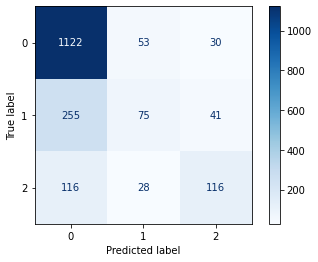

In [11]:
# plot the confusion matrix
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm, display_labels=rs_gbc.classes_).plot(cmap='Blues');

The accuracy scores from the training and testing data from this Randomized Search did not change much compared to the scores from the model with default parameters from the preliminary modeling. The test score has increased by 0.38. However, the recall score has improved by 4%, which is the score we are optimizing for.

In [ ]:
# # Instatiate GridSearch object
# gs_gbc = GridSearchCV(gs_pipe,
#                      pipe_params,
#                      cv=5,
#                      verbose=1)